# Create Dask Cluster using dask_cloudprovider

In this notebook a dask cluster will be created using the `EC2Cluster` that is available in `dask_cloudprovider`.

## Create necessary permissions

### 1. IAM user
In order to create this cluster you need permission to EC2 resources. In the exercises the cluster uses data in S3. Therefore as user was created with programmatic access that has `AmazonS3FullAccesss` and `AmazonEC2FullAccess` policies attached. If you intend to provide an IAM role you also need `IAMFullAccess`. `AmazonEC2ContainerRegistryFullAccess`

### 2. EC2 role

Create a role `dask-cluster-ec2-role` with `AmazonS3FullAccesss` and  `AmazonEC2ContainerRegistryFullAccess`

### 2. key pair

Creat a key pair `dask-keys`.



### Rest

In [ ]:
from dask.distributed import Client
from dask_cloudprovider.aws import EC2Cluster
from typing import List, Optional

import dask.array as da
import dask.dataframe as dd

check if we have sufficient permissions

check s3 permissions

In [ ]:
# check s3 permissions
# !aws s3 ls

check ec2 permissions

In [ ]:
# Check ec2 permissions
#!aws ec2 describe-subnets

check iam permissions

In [ ]:
# !aws iam list-users

#### Create the cluster on AWS

In order to use the EC2Cluster class we need to set `security=False` otherwise an error message was returned.

**remark**:
- When using ACG sandboxes the region **must** be `us-east-1`

## TODO

- include outbound traffic on 80 and 443

**remark**:
- from dask discord we received a hint to use `env_vars` to install extra packages. However this does not work. 

In [ ]:
cluster = EC2Cluster(
                     region="us-east-1",
                     availability_zone= None,
                     bootstrap= True,  # to install docker on the image
                     auto_shutdown= None,
                     ami= None,
                     instance_type= None,
                     scheduler_instance_type='t2.micro',
                     worker_instance_type= 't2.medium', 
                     vpc= None,
                     subnet_id = None,
                     security_groups = None,
                     filesystem_size= None,
                     key_name= "dask-keys",
                     # the Name is the IAM role name
                     iam_instance_profile= {'Name': 'dask-cluster-ec2-role'},
                     n_workers= 2,
                     docker_image = "daskdev/dask:latest", 
                     docker_args = None,
                     debug = False,
                     security = False,
                     #env_vars={'EXTRA_CONDA_PACKAGES': 's3fs'}
)

Below works!!!!

In [ ]:
cluster.get_logs()

you can always scale a cluster using `.scale(n)` where `n` is the number of worker instances

In [ ]:
client = Client(cluster)
client

### Manual installation of s3fs

In [ ]:
# Check if 's3fs' is installed on the workers
def check_s3fs():
    try:
        import s3fs
        return True
    except ImportError:
        return False

# Run the check on all workers
print(client.run(check_s3fs))

install on workers

In [ ]:
client.run(lambda: __import__('subprocess').check_call(['pip3', 'install', 's3fs']))

# Run the check on all workers
print(client.run(check_s3fs))

install on scheduler

In [ ]:
# Install s3fs on the scheduler
client.run_on_scheduler(lambda: __import__('subprocess').check_call(['pip3', 'install', 's3fs']))

# Run the check on all workers
print(client.run_on_scheduler(check_s3fs))

In [ ]:
# client.get_worker_logs()

In [ ]:
#print(cluster.get_logs())

### Cluster in action

In [ ]:
import dask.array as da

a_da = da.ones(10, chunks=5)
a_da

In [ ]:
a_da_sum = a_da.sum()
a_da_sum

In [ ]:
a_da_sum.compute()

In [ ]:
xd = da.random.normal(10, 0.1, size=(40_000, 40_000), chunks=(3000, 3000))
xd

In [ ]:
%%time
xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000))
yd = xd.mean(axis=0)
yd.compute()

Let's try to point the cluster to data on S3

In [ ]:
import dask.dataframe as dd

# Read all CSV files from the root of the bucket
ddf = dd.read_csv("s3://dask-input-bucket/*.csv", 
                  dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                  blocksize="25MB" )

ddf

In [ ]:
ddf.head()

In [ ]:
%%time
result = ddf.DepDelay.max()
result.compute()

In [ ]:
client.close()

In [ ]:
cluster.close()

## Create cluster using containers locally

First we try to create a docker images that contains all dependencies and that works locally - **in progress**

create a requirements file that matches the dependencies on local machine

In [ ]:
%%writefile ./docker/requirements.txt
pandas==2.2.3
numpy==2.1.0
dask[complete]==2024.9.1
dask-cloudprovider==2024.9.0
s3fs==2024.9.0
dask-expr==1.1.15
awscli
jupyter

Create a simple Dockerfile

In [ ]:
%%writefile ./docker/Dockerfile
FROM python:3.10.12-slim

WORKDIR app
COPY ./docker/requirements.txt .

RUN pip3 install --upgrade pip

RUN pip3 install -r requirements.txt

EXPOSE 8786 8787 30000-65535

CMD ["dask", "scheduler", "--host", "0.0.0.0"]
#CMD ["dask", "scheduler"]

build the image and give it the tag `test-dask-image`

**remark** - building this image takes more than 15 minutes

In [ ]:
!docker build . -t dask-cluster-image -f ./docker/Dockerfile

when running the container we want to test expose several ports and use the host network

#### Create a network

We will have create 3 containers that need to communicate these need a network to share communcation

In [ ]:
!docker network create dask-net

In [ ]:
!docker network ls

#### Case 1 - expose ports

Below we create the scheduler container with pors 8786-8787 open en connect to the dask-net network.

In [ ]:
!docker run -d --rm --name dask-scheduler --network dask-net -p 8786:8786 -p 8787:8787 dask-image

In [ ]:
!docker ps

check the logs that the service has started

In [ ]:
!docker logs dask-scheduler

now create dask-worker-1

In [ ]:
!docker run -d --rm --name dask-worker-1 --network dask-net dask-image dask-worker tcp://dask-scheduler:8786

In [ ]:
!docker ps

In [ ]:
!docker logs dask-worker-1

create a second worker

In [ ]:
!docker run -d --rm --name dask-worker-2 --network dask-net dask-image dask-worker tcp://dask-scheduler:8786

In [ ]:
!docker ps

In [ ]:
!docker logs dask-worker-2

In [ ]:
from dask.distributed import Client

client = Client("tcp://localhost:8786")

client

In [ ]:
%%time
import dask.array as da

# Create a Dask array and perform some computations
array = da.random.random((30000, 30000), chunks=(1000, 1000))
result = array.mean().compute()

print(result)

#### clean up!

In [ ]:
client.close()

# docker clean up
!docker stop dask-scheduler
!docker stop dask-worker-1
!docker stop dask-worker-2
!docker network rm dask-net

This all works !!!!

## Create a dask cluster on EC2 instances

### Priliminary work

- Create IAM role (see at the top)
- Creat USER (see at the top)
- Create a key pair (see at the top)
- Create an Amazon ECR Repository
    - Navigate to Amazon ECR in the AWS Management Console.
    - Click Create Repository.
    - Name your repository, e.g., `dask-cluster-image`.
    - Choose other settings as needed, then click Create Repository.

The below commands are provided when you select the radio button of the repository and then click `view push commands`

In [ ]:
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 654654225119.dkr.ecr.us-east-1.amazonaws.com

In [ ]:
!docker tag dask-cluster-image:latest 654654225119.dkr.ecr.us-east-1.amazonaws.com/dask-cluster-image:latest

In [ ]:
!docker push 654654225119.dkr.ecr.us-east-1.amazonaws.com/dask-cluster-image:latest

start 2 EC2 instances and use the user script below

**remark** - change the last command to match the sandbox account

make sure you link your `dask-keys` and the `dask-ec2-role` that you created earlier. 

while the instances are created open ports on the security group

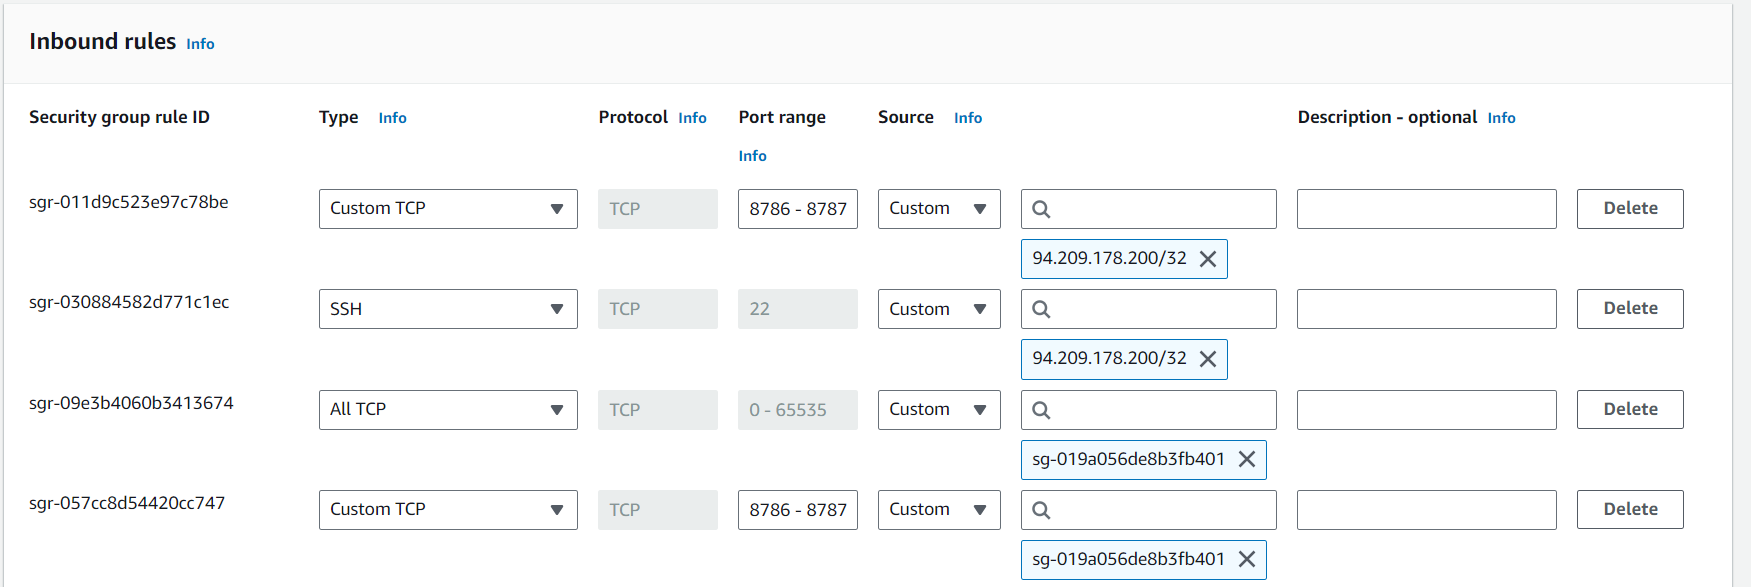

On all instances pull down the image

on scheduler

on worker - please note we use `--network host` such that all ports are open

you need to adjust the `<accountnr>.dkr` part and the internal address in tcp

under construction below does not work 

- /var/log/cloud-init.log
- /var/log/cloud-init-output.log

In [1]:
from dask.distributed import Client

client = Client("tcp://44.206.236.130:8786")

client

<Client: 'tcp://172.17.0.2:8786' processes=1 threads=2, memory=3.82 GiB>

2024-10-21 21:48:47,263 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [2]:
%%time 
import dask.array as da

xd = da.random.normal(10, 0.1, size=(10_000, 10_000), chunks=(3000, 3000))
yd = xd.mean(axis=0)
yd.compute()

2024-10-21 19:30:01,738 - distributed.client - WARNING - Couldn't gather 4 keys, rescheduling (('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 0), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 1), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 2), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 3))
2024-10-21 19:30:32,087 - distributed.client - WARNING - Couldn't gather 4 keys, rescheduling (('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 0), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 1), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 2), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 3))
2024-10-21 19:31:02,306 - distributed.client - WARNING - Couldn't gather 4 keys, rescheduling (('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 0), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 1), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910', 2), ('mean_agg-aggregate-4bfb3df8d60832850726db89a5331910',

KeyboardInterrupt: 

In [ ]:
import dask.dataframe as dd


# Read all CSV files from the root of the bucket
# ddf = dd.read_csv("s3://dask-input-data/*.csv", 
#                   parse_dates={"Date": [0, 1, 2]},
#                   dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
#                   blocksize="10MB" )

# Read all CSV files from the root of the bucket
ddf = dd.read_csv("s3://dask-input-data/*.csv", 
                  dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                  blocksize="25MB" )


ddf

In [ ]:
%%time
len(ddf)

In [ ]:
%%time 
ddf[~ddf.Cancelled].groupby("Origin")["Origin"].count().compute()

In [ ]:
client.close()